# SARA MALALAN

## Homework 2

Fully connected neural network on STL10 dataset.

In [90]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from IPython import display

torch.manual_seed(2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
def get_params_num(net):
    return sum(map(torch.numel, net.parameters()))

    
def get_accuracy(dataloader, model, device='cpu'):
    tot = len(dataloader.dataset)
    with torch.no_grad():
        n_right = 0
        for data in dataloader:
            batch = data[0].to(device)
            labels = data[1].to(device)
            
            outputs = model(batch)
            out_labels = torch.argmax(outputs, dim=1)
            n_right += torch.sum(labels == out_labels)
    return float(n_right) / tot

Device: cpu


In [91]:
# import STL10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.STL10(root='./data', split="train",
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.STL10(root='./data', split="test",
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


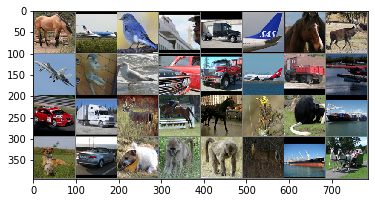

horse airplane  bird  ship truck airplane horse  deer airplane monkey  bird   car truck airplane truck airplane   car truck  deer horse horse  bird monkey  ship   dog   car   dog monkey monkey  deer  ship horse


In [92]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

In [93]:
print(trainset)

Dataset STL10
    Number of datapoints: 5000
    Root location: ./data
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [94]:
print("trainset.data type: {}".format(type(trainset.data)))
print("CIFAR images shape: {}".format(tuple(trainset[0][0].shape)))

trainset.data type: <class 'numpy.ndarray'>
CIFAR images shape: (3, 96, 96)


In [95]:
class FCnn(nn.Module):
    def __init__(self):
        super(FCnn, self).__init__()
        self.input_dim = 3 * 96 * 96
        self.n_classes = 10
        self.fc1 = nn.Linear(self.input_dim, 400)
        self.fc2 = nn.Linear(400,400)
        self.fc3 = nn.Linear(400,400)
        self.out = nn.Linear(400, self.n_classes)
    
    def forward(self, x):
        x = x.view(-1, self.input_dim) # flattening
        x = F.relu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.celu(self.fc3(x))
        x = self.out(x) 
        return x
        
net = FCnn()
net.to(device)
print("# of parameters: {}".format(get_params_num(net)))
print(net)

# of parameters: 11384410
FCnn(
  (fc1): Linear(in_features=27648, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=400, bias=True)
  (out): Linear(in_features=400, out_features=10, bias=True)
)


In [99]:
lr = 0.0001
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [100]:
epochs = 10

n_batches = len(trainloader)
for e in range(epochs):
    for i, data in enumerate(trainloader):
        batch = data[0].to(device)
        labels = data[1].to(device)      
        outputs = net(batch)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print("[EPOCH]: {}, [BATCH]: {}/{}, [LOSS]: {}".format(e, i, n_batches, loss.item()))
            display.clear_output(wait=True)

[EPOCH]: 9, [BATCH]: 150/157, [LOSS]: 0.1435898393392563


In [101]:
acc_train = get_accuracy(trainloader, net, device=device)
acc_test = get_accuracy(testloader, net, device=device)
print("Train accuracy: {}\nTest accuracy: {}".format(acc_train, acc_test))

Train accuracy: 0.9722
Test accuracy: 0.409


It works very well on the training set while on the test set the accuracy is not so good (still better than a random classifier since there are 10 classes).